In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from scipy.spatial import distance
import pickle

from create_problem import Problem
from solve_flo import FLO_Solver
df = pd.read_excel("pca_hgdp_kg.xlsx")
data = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15'
    , 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']]

regions = ['Oceania', 'America', 'EUR', 'Europe', 'Central_South_Asia', 'SAS', 'Africa', 'EAS', 'AFR', 'Est_Asia',
           'AMR', 'Middle_Est']

target = df['Region']
size = data.shape[0]

with open('distance.pickle', 'rb') as handle:
    d = pickle.load(handle)
d = np.array(d)
d = d * 100
d = d.astype(int)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=123)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()  # for plot styling
def all_purity(x, labels):
    total = 0
    pur = 0
    for i in x.values():
        total += len(i)
        pur += purity(i, labels) * len(i)
    return pur / total


def purity(arr, labels):
    aa = [labels[i] for i in arr]  # aa = [labels[i] for i in arr]
    c = [aa.count(i) for i in regions]  # c = [aa.count(i) for i in range(3)]
    return max(c) / len(aa)

def maxFreq(arr):
    # Using moore's voting algorithm
    n = len(arr)
    res = 0
    count = 1

    for i in range(1, n):
        if arr[i] == arr[res]:
            count += 1
        else:
            count -= 1

        if count == 0:
            res = i
            count = 1

    return arr[res]

def result_info(flo):
    print(f'primal {flo.solution.primal_value} - dual {flo.solution.dual_value}')
    exe = list(flo.solution.exe)
    x = {i: [] for i in exe}
    outliers = []

    for i, e in flo.solution.assigns.items():
        if e == 'o':
            outliers.append(i)
        else:
            x[e].append(i)

    print('primal', flo.solution.primal_value, 'dual', flo.solution.dual_value)
    print(f"outliers {outliers}")
    print(f"exemplars {x.keys()}")
    print(f'number of clusters {len(exe)}')
    print(f'purity {all_purity(x, target)}')

    yy = {i: maxFreq([target[j] for j in x[i]]) for i in exe}

    print('ratio', flo.solution.primal_value / flo.solution.dual_value)
    print('number of clusters', len(flo.solution.exe))

    from sklearn.metrics.cluster import v_measure_score
    predicted = [yy[flo.solution.assigns[i]] for i in range(p.n) if flo.solution.assigns[i] != 'o']
    t = [target[i] for i in range(p.n) if flo.solution.assigns[i] != 'o']
    print('v-measure', v_measure_score(t, predicted))
    from sklearn.metrics.cluster import homogeneity_score
    print('homogeneity', homogeneity_score(t, predicted))
    from sklearn.metrics.cluster import completeness_score
    print('completeness', completeness_score(t, predicted))
    print('')
    return x

def plot_result(flo):
    exe = list(flo.solution.exe)
    x = {i: [] for i in exe}
    outliers = []

    for i, e in flo.solution.assigns.items():
        if e == 'o':
            outliers.append(i)
        else:
            x[e].append(i)
    
    colors = iter(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
    for cluster in x.keys():
        color = next(colors)
        plt.scatter(principalDf.loc[x[cluster], 'principal component 1'],
                principalDf.loc[x[cluster], 'principal component 2'],
                s=50, c=color)
    plt.show()

    colors = iter(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
    
    for cluster in x.keys():
        color = next(colors)
        plt.scatter(principalDf.loc[x[cluster], 'principal component 1'],
                principalDf.loc[x[cluster], 'principal component 2'],
                s=50, c=color)
        plt.xlim(-0.06,0.18)
        plt.ylim(-0.12,0.16)
        print(cluster, maxFreq([target[j] for j in x[cluster]]), purity(x[cluster], target), len(x[cluster]))
        plt.show()
    

# no constraint

primal 12031 - dual 6915.0
primal 12031 dual 6915.0
outliers []
exemplars dict_keys([898, 395, 781, 272, 149, 664, 540, 2993, 1082, 705, 199, 2250, 1242, 611, 363, 750, 1777, 116, 373])
number of clusters 19
purity 0.7400620242458416
ratio 1.7398409255242226
number of clusters 19
v-measure 0.796487910273113
homogeneity 0.7208722568183752
completeness 0.8898258993617097



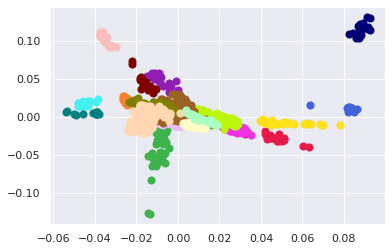

898 Middle_Est 1.0 27


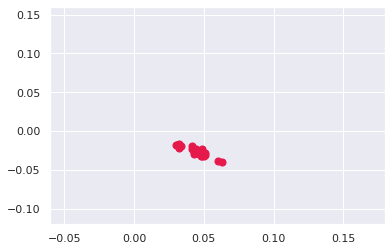

395 Middle_Est 1.0 126


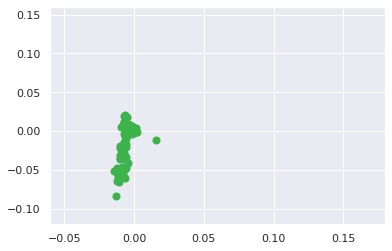

781 Africa 1.0 31


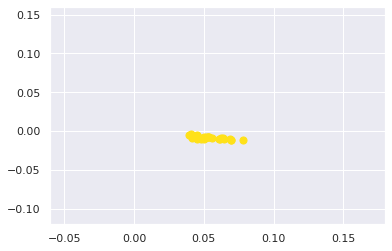

272 Oceania 1.0 17


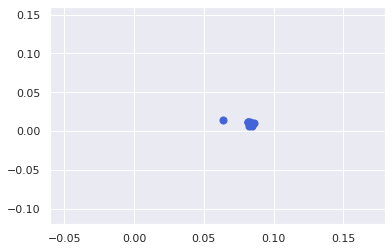

149 Central_South_Asia 1.0 25


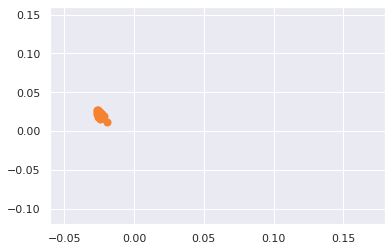

664 Est_Asia 1.0 29


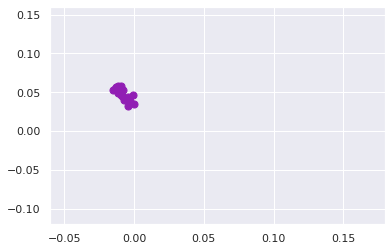

540 America 1.0 21


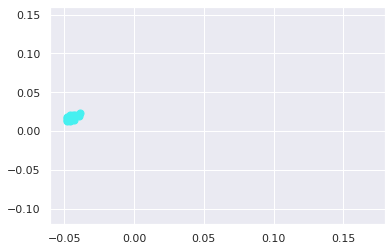

2993 EAS 0.7862595419847328 131


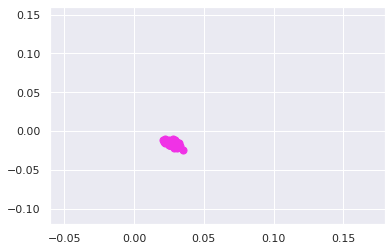

1082 EUR 0.5539647577092511 908


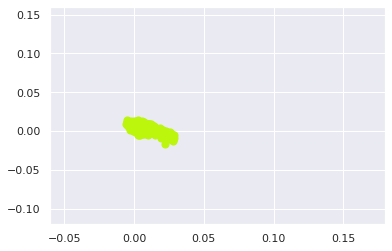

705 America 1.0 23


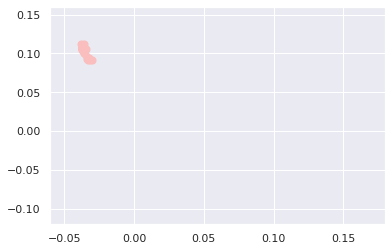

199 Africa 1.0 21


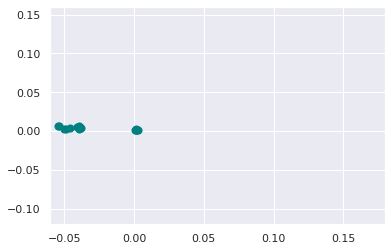

2250 AFR 0.9037328094302554 509


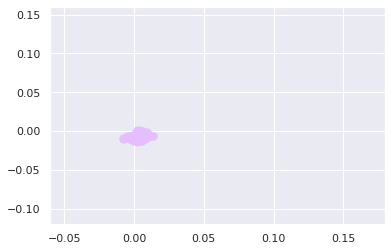

1242 EAS 0.6552287581699346 612


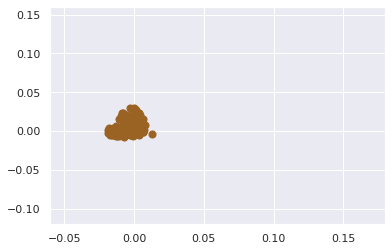

611 AFR 0.8918918918918919 222


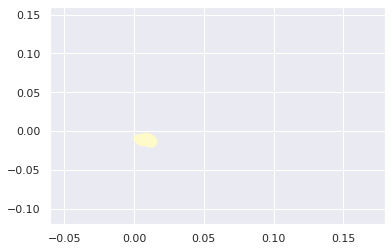

363 Middle_Est 1.0 20


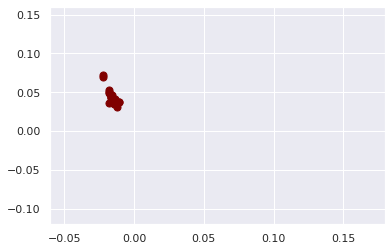

750 America 1.0 25


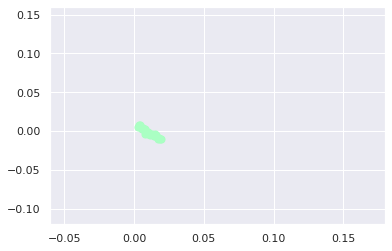

1777 AMR 0.6850393700787402 127


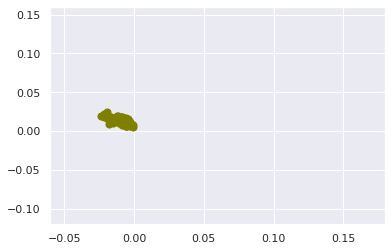

116 SAS 0.7477064220183486 654


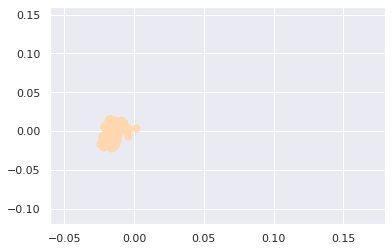

373 Oceania 1.0 19


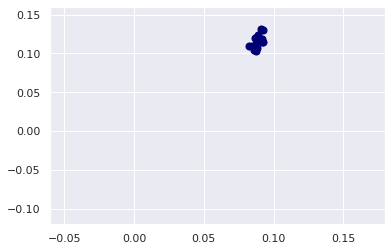

In [2]:
ls = []
C = [100 for _ in range(size)]
B = []
for ii in ls:
    lll = [0 for i in range(size)]
    lll[ii[0]] = lll[ii[1]] = 1
    B.append(lll)
S = []
l = 0
p = Problem(d, C, B, S, l)
a = FLO_Solver(p)
x = result_info(a)
plot_result(a)

In [ ]:
keyskeys

# cluster 1082

Oceania 0
America 0
EUR 503
Europe 143
Central_South_Asia 0
SAS 0
Africa 1
EAS 0
AFR 3
Est_Asia 0
AMR 257
Middle_Est 1
['AMR', 'EUR']


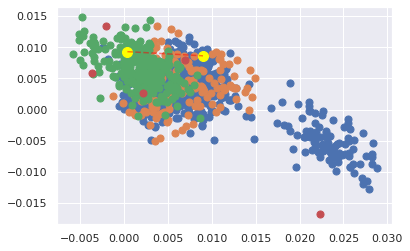

In [26]:
z = x[1082]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))
    
x1 = [i for i in z if target[i] == 'EUR']
x2 = [i for i in z if target[i] == 'Europe']
x3 = [i for i in z if target[i] == 'AMR']
x4 = [i for i in z if i not in x1+x2+x3]

plt.scatter(principalDf.loc[x1, 'principal component 1'],
            principalDf.loc[x1, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x2, 'principal component 1'],
            principalDf.loc[x2, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x3, 'principal component 1'],
            principalDf.loc[x3, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x4, 'principal component 1'],
            principalDf.loc[x4, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[1497, 'principal component 1'],
            principalDf.loc[1497, 'principal component 2'],
            s=100, c='yellow')
plt.scatter(principalDf.loc[1043, 'principal component 1'],
            principalDf.loc[1043, 'principal component 2'],
            s=100,c='yellow')
row = [1497, 1043]
print([target[i] for i in row])
plt.plot(principalDf.iloc[row, 0], principalDf.iloc[row, 1], c='red', alpha=0.5, linestyle='--')
plt.show()

primal 12064 - dual 6915
primal 12064 dual 6915
outliers []
exemplars dict_keys([898, 395, 781, 272, 149, 664, 540, 1568, 2993, 1082, 705, 199, 2250, 1242, 611, 363, 750, 1777, 116, 373])
number of clusters 20
purity 0.8054694107696645
ratio 1.7446131597975416
number of clusters 20
v-measure 0.8267904815016518
homogeneity 0.764811720531207
completeness 0.8997003371487953



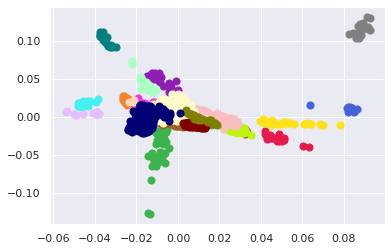

898 Middle_Est 1.0 27


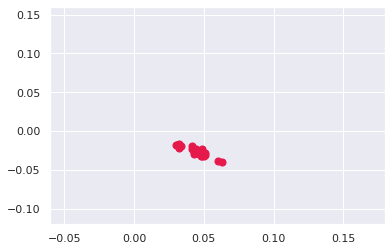

395 Middle_Est 1.0 126


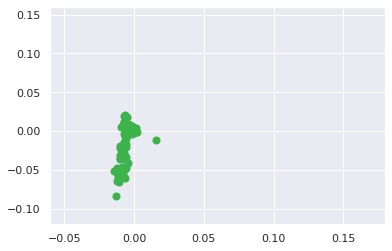

781 Africa 1.0 31


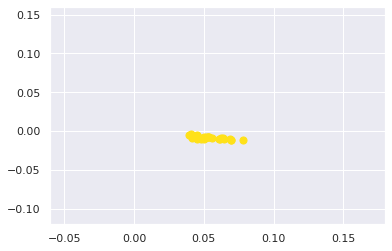

272 Oceania 1.0 17


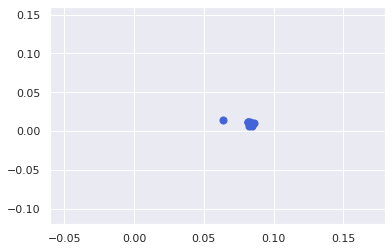

149 Central_South_Asia 1.0 25


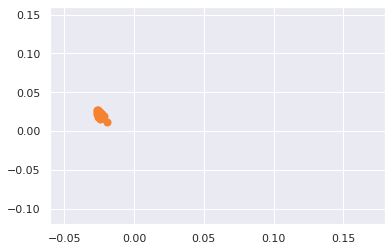

664 Est_Asia 1.0 29


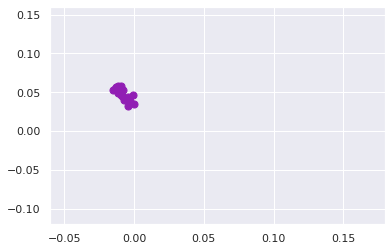

540 America 1.0 21


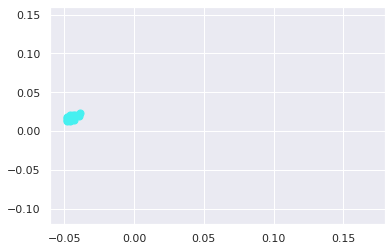

1568 AMR 0.8259803921568627 408


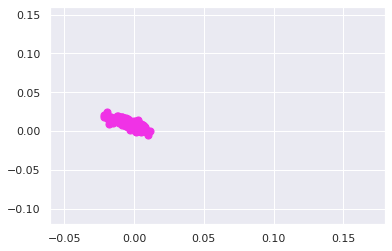

2993 EAS 0.7862595419847328 131


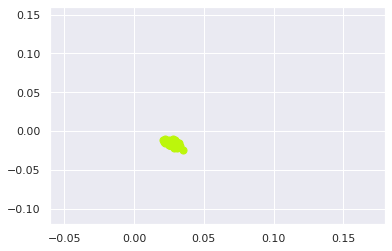

1082 EUR 0.7745571658615137 621


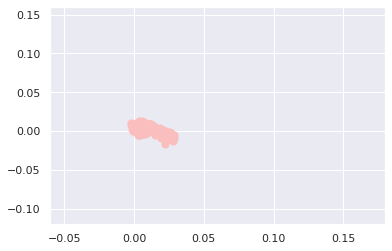

705 America 1.0 23


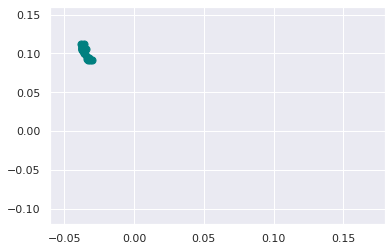

199 Africa 1.0 21


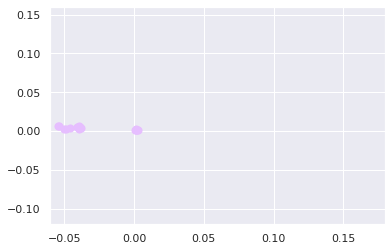

2250 AFR 0.9037328094302554 509


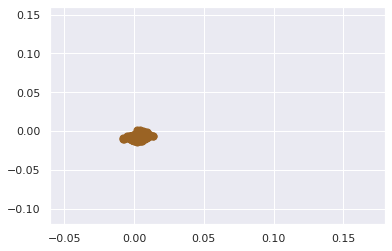

1242 EAS 0.6552287581699346 612


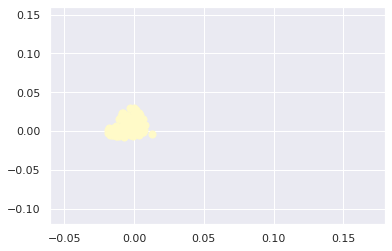

611 AFR 0.8918918918918919 222


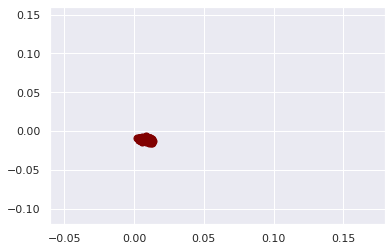

363 Middle_Est 1.0 20


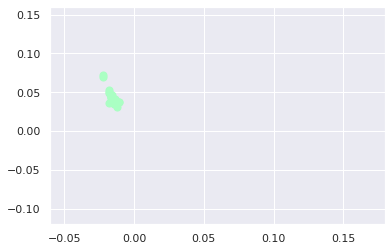

750 America 1.0 25


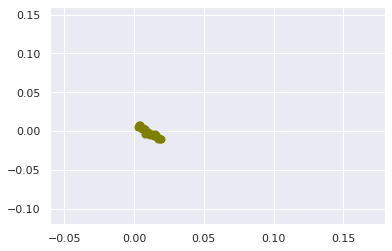

1777 America 0.6666666666666666 6


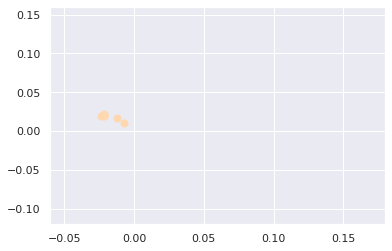

116 SAS 0.7477064220183486 654


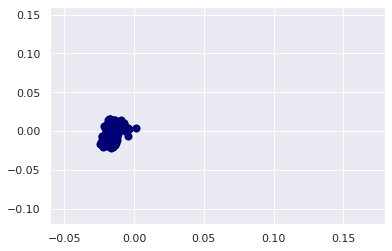

373 Oceania 1.0 19


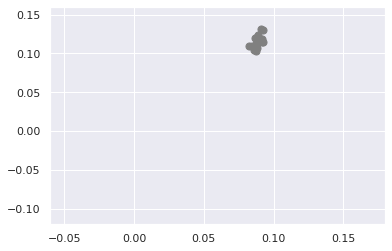

In [20]:
ls = [
    [1497, 1043]
]
C = [100 for _ in range(size)]
B = []
for ii in ls:
    lll = [0 for i in range(size)]
    lll[ii[0]] = lll[ii[1]] = 1
    B.append(lll)
S = []
l = 0
p = Problem(d, C, B, S, l)
b = FLO_Solver(p)
x1 = result_info(b)
plot_result(b)

after cluster

In [131]:
z = x1[1082]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))

print('--------------')
z = x1[1568]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))



Oceania 0
America 0
EUR 481
Europe 133
Central_South_Asia 0
SAS 0
Africa 1
EAS 0
AFR 0
Est_Asia 0
AMR 5
Middle_Est 1
--------------
Oceania 0
America 35
EUR 22
Europe 10
Central_South_Asia 0
SAS 0
Africa 0
EAS 0
AFR 3
Est_Asia 1
AMR 337
Middle_Est 0


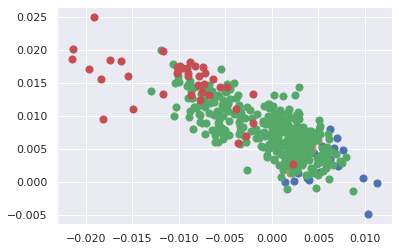

In [25]:
z = x1[1568]

x11 = [i for i in z if target[i] == 'EUR']
x22 = [i for i in z if target[i] == 'Europe']
x33 = [i for i in z if target[i] == 'AMR']
x44 = [i for i in z if i not in x11+x22+x33]
plt.scatter(principalDf.loc[x11, 'principal component 1'],
            principalDf.loc[x11, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x22, 'principal component 1'],
            principalDf.loc[x22, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x33, 'principal component 1'],
            principalDf.loc[x33, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[x44, 'principal component 1'],
            principalDf.loc[x44, 'principal component 2'],
            s=50,)

plt.show()

# cluster 116

Oceania 0
America 0
EUR 0
Europe 17
Central_South_Asia 148
SAS 489
Africa 0
EAS 0
AFR 0
Est_Asia 0
AMR 0
Middle_Est 0
primal 11908 - dual 6915
primal 11908 dual 6915
outliers []
exemplars dict_keys([898, 395, 781, 272, 149, 664, 540, 1568, 2993, 1082, 705, 199, 2250, 85, 1242, 611, 363, 750, 1777, 116, 373])
number of clusters 21
purity 0.822385114180998
ratio 1.7220535068691252
number of clusters 21
v-measure 0.8319698880426629
homogeneity 0.7772987141840622
completeness 0.8949134763451726



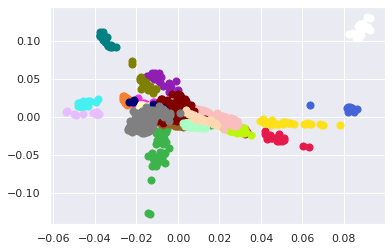

898 Middle_Est 1.0 27


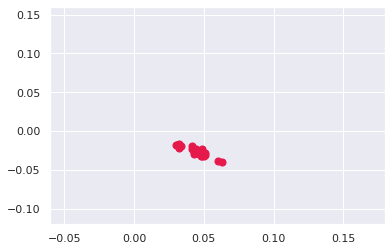

395 Middle_Est 1.0 126


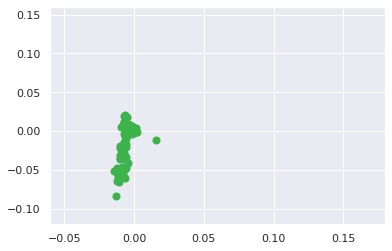

781 Africa 1.0 31


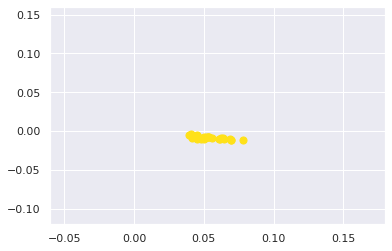

272 Oceania 1.0 17


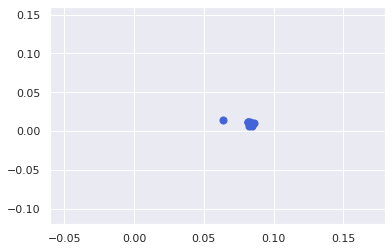

149 Central_South_Asia 1.0 25


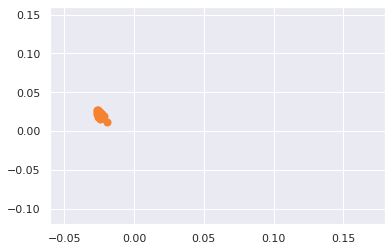

664 Est_Asia 1.0 29


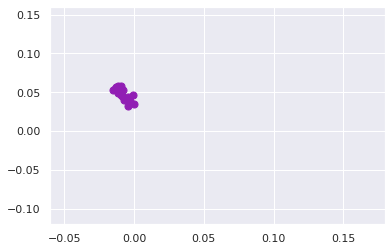

540 America 1.0 21


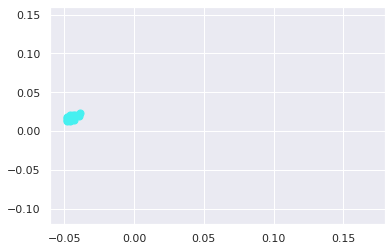

1568 AMR 0.8259803921568627 408


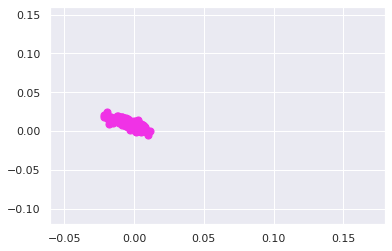

2993 EAS 0.7862595419847328 131


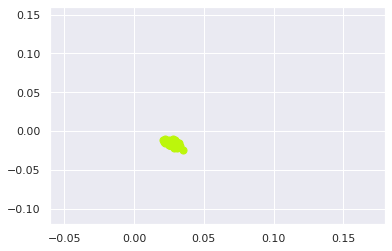

1082 EUR 0.7745571658615137 621


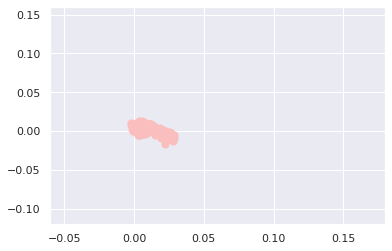

705 America 1.0 23


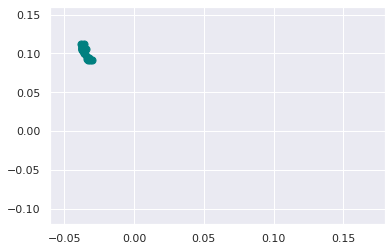

199 Africa 1.0 21


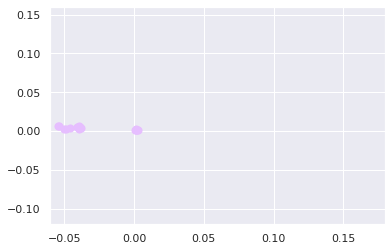

2250 AFR 0.9037328094302554 509


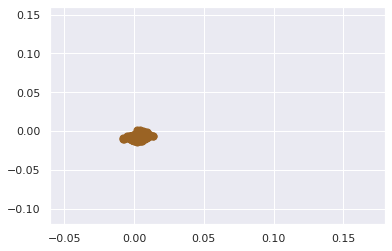

85 Central_South_Asia 1.0 60


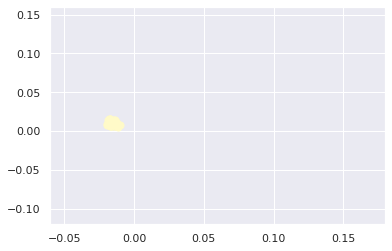

1242 EAS 0.6552287581699346 612


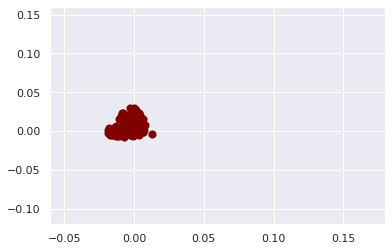

611 AFR 0.8918918918918919 222


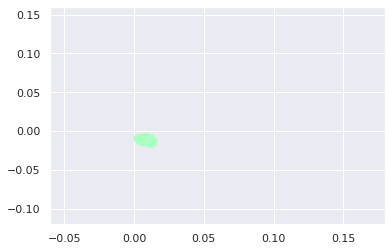

363 Middle_Est 1.0 20


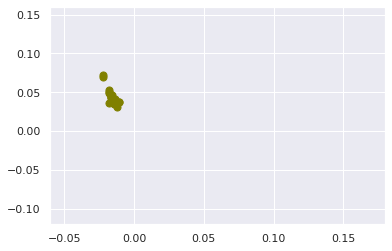

750 America 1.0 25


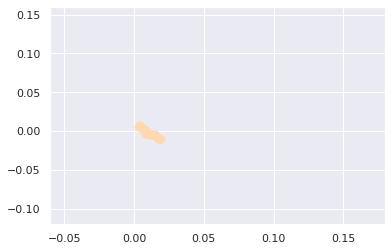

1777 America 0.6666666666666666 6


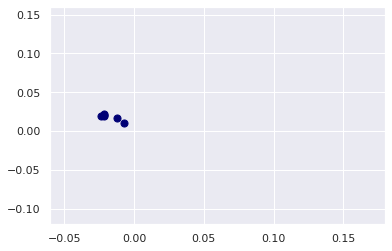

116 SAS 0.8232323232323232 594


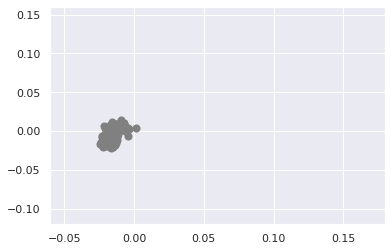

373 Oceania 1.0 19


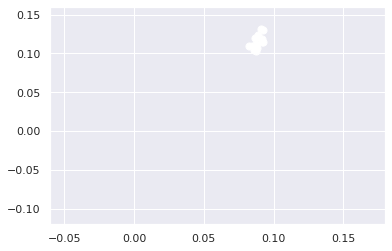

In [132]:
q = x1[116]
qq = [target[i] for i in q]
for w in regions:
    print(w, qq.count(w))
C = [100 for _ in range(size)]
B = [[0 for i in range(size)],[0 for i in range(size)]]
B[0][1497] = B[0][1043] = 1
B[1][85] = B[1][3464] = 1
        
S = []
l = 0
p = Problem(d, C, B, S, l)
c = FLO_Solver(p)
x2 = result_info(c)
plot_result(c)

after clustering

In [133]:
z = x2[116]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))

print('--------------')
z = x2[85]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))

Oceania 0
America 0
EUR 0
Europe 17
Central_South_Asia 88
SAS 489
Africa 0
EAS 0
AFR 0
Est_Asia 0
AMR 0
Middle_Est 0
--------------
Oceania 0
America 0
EUR 0
Europe 0
Central_South_Asia 60
SAS 0
Africa 0
EAS 0
AFR 0
Est_Asia 0
AMR 0
Middle_Est 0


# clustering 1082

In [134]:
clusters = {1082:['EUR','Europe'], 1242:['EAS', 'Est_Asia']}
z = x2[1242]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))

Oceania 0
America 0
EUR 0
Europe 0
Central_South_Asia 34
SAS 0
Africa 0
EAS 401
AFR 0
Est_Asia 177
AMR 0
Middle_Est 0


In [135]:
distance1 = set()
distance2 = set()
client_edges = {i: [] for i in range(p.n)}
facility_edges = {i: [] for i in c.facilities_paid_for}
for i in range(c.p.n):
    if i not in c.facilities_paid_for:
        continue
    for j in range(c.p.n):
        if c.alpha[j] - c.beta[i, j] - sum([c.p.B[r, j] * c.gamma[r, i] for r in range(c.p.r)]) >= c.p.D[i, j]:
            client_edges[j].append(i)
            facility_edges[i].append(j)

center = 1242
distance1=set(facility_edges[center])
distance2 = set()
for i in distance1:
    distance2.update([j for j in client_edges[i]])
distance2 = distance2 - distance1
distance2 = list(distance2)
distance2
distance2.sort()

[i for i in facility_edges[1242] if i in facility_edges[987]]
target[493]

'Est_Asia'

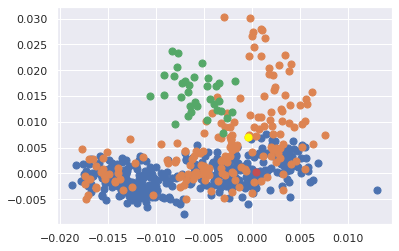

In [136]:
q1 = [i for i in x2[center] if target[i] == 'EAS']
q2 = [i for i in x2[center] if target[i] == 'Est_Asia']
q3 = [i for i in x2[center] if target[i] == 'Central_South_Asia']

plt.scatter(principalDf.loc[q1, 'principal component 1'],
            principalDf.loc[q1, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[q2, 'principal component 1'],
            principalDf.loc[q2, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[q3, 'principal component 1'],
            principalDf.loc[q3, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[center, 'principal component 1'],
            principalDf.loc[center, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[987, 'principal component 1'],
            principalDf.loc[987, 'principal component 2'],
            s=50,c='yellow')

plt.show()


In [137]:
936,859
940,863
933,822 
932, 785
C = [100 for _ in range(size)]
B = [[0 for i in range(size)],[0 for i in range(size)],[0 for i in range(size)],[0 for i in range(size)],[0 for i in range(size)],[0 for i in range(size)],]
B[0][1497] = B[0][1043] = 1
B[1][85] = B[1][3464] = 1
B[2][936] = B[2][859] = 1
B[3][940] = B[3][863] = 1
B[4][933] = B[4][822] = 1
B[5][932] = B[5][785] = 1

S = []
l = 0
p = Problem(d, C, B, S, l)
c1 = FLO_Solver(p)
x3 = result_info(c1)

    

primal 12009 - dual 6915
primal 12009 dual 6915
outliers []
exemplars dict_keys([898, 395, 2828, 781, 272, 149, 540, 1568, 2993, 1082, 705, 199, 2250, 85, 1242, 987, 611, 363, 750, 1777, 116, 373])
number of clusters 22
purity 0.8283056103749648
ratio 1.736659436008677
number of clusters 22
v-measure 0.8354399934528749
homogeneity 0.7849338158841672
completeness 0.892892734139639



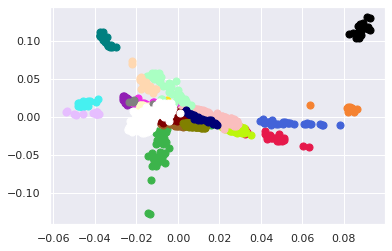

898 Middle_Est 1.0 27


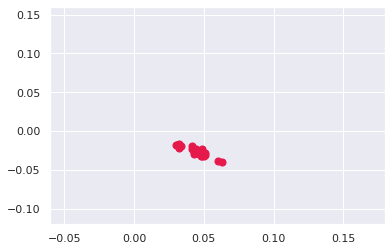

395 Middle_Est 1.0 126


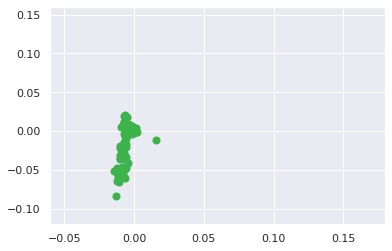

2828 EAS 0.47474747474747475 99


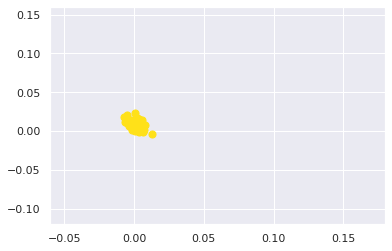

781 Africa 1.0 31


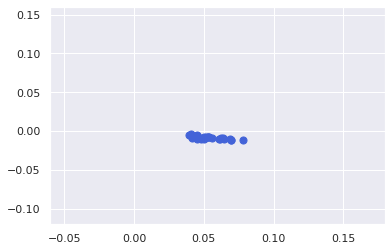

272 Oceania 1.0 17


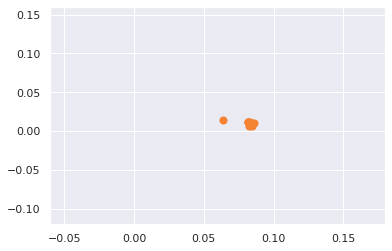

149 Central_South_Asia 1.0 25


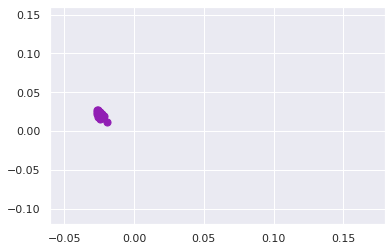

540 America 1.0 21


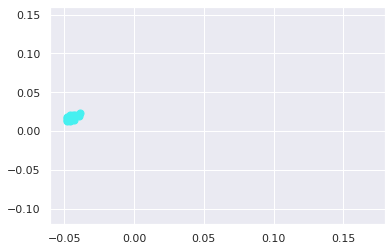

1568 AMR 0.8259803921568627 408


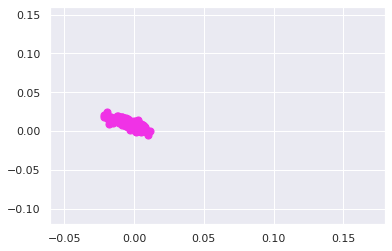

2993 EAS 0.7862595419847328 131


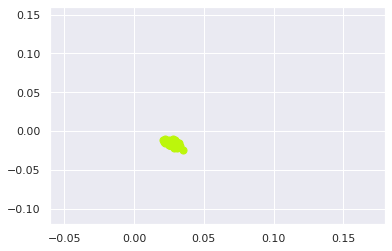

1082 EUR 0.7745571658615137 621


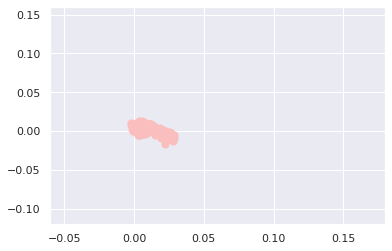

705 America 1.0 23


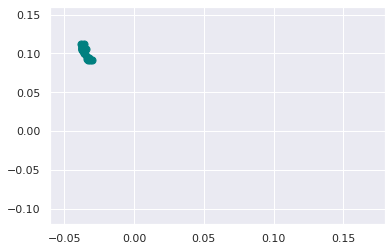

199 Africa 1.0 21


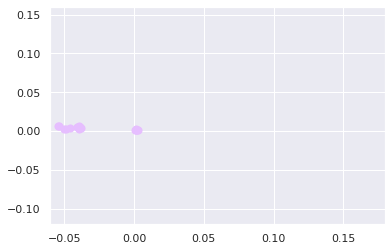

2250 AFR 0.9037328094302554 509


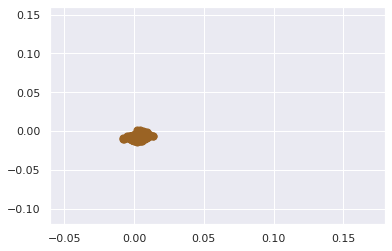

85 Central_South_Asia 1.0 60


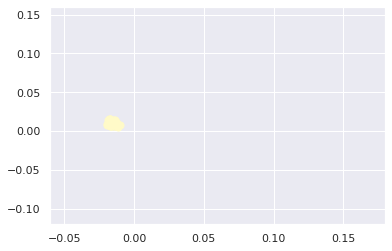

1242 EAS 0.7611940298507462 469


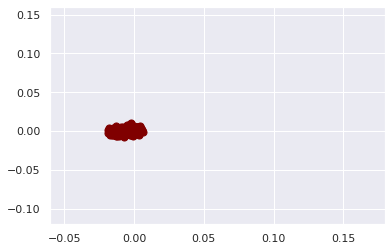

987 Est_Asia 0.8103448275862069 58


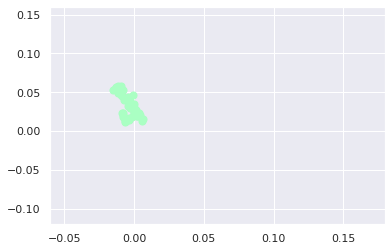

611 AFR 0.8918918918918919 222


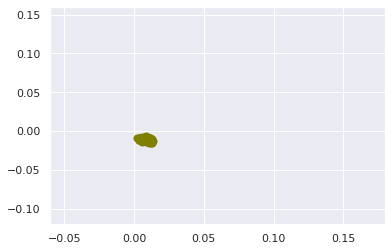

363 Middle_Est 1.0 20


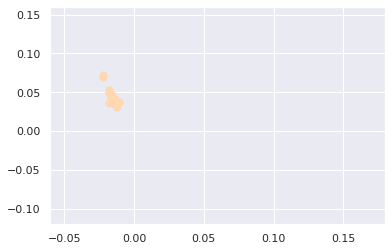

750 America 1.0 25


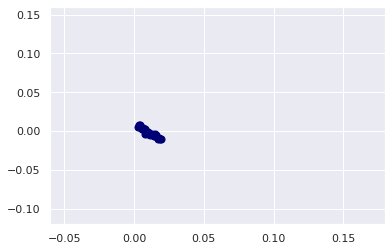

1777 America 0.6666666666666666 6


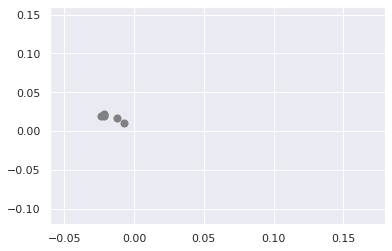

116 SAS 0.8029556650246306 609


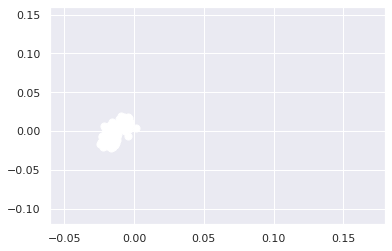

373 Oceania 1.0 19


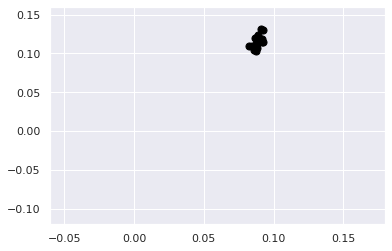

In [138]:
plot_result(c1)

In [139]:
print('added cluster')
print([i for i in x3.keys() if i not in x2.keys()])
print('deleted')
[i for i in x2.keys() if i not in x3.keys()]

added cluster
[2828, 987]
deleted


[664]

Oceania 0
America 0
EUR 0
Europe 17
Central_South_Asia 103
SAS 489
Africa 0
EAS 0
AFR 0
Est_Asia 0
AMR 0
Middle_Est 0


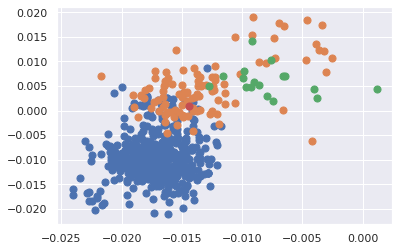

In [140]:
center = 116
z = x3[center]
zz = [target[i] for i in z]
for i in regions:
    print(i, zz.count(i))
q1 = [i for i in x3[center] if target[i] == 'SAS']
q2 = [i for i in x3[center] if target[i] == 'Central_South_Asia']
q3 = [i for i in x3[center] if target[i] == 'Europe']

plt.scatter(principalDf.loc[q1, 'principal component 1'],
            principalDf.loc[q1, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[q2, 'principal component 1'],
            principalDf.loc[q2, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[q3, 'principal component 1'],
            principalDf.loc[q3, 'principal component 2'],
            s=50,)
plt.scatter(principalDf.loc[center, 'principal component 1'],
            principalDf.loc[center, 'principal component 2'],
            s=50,)


plt.show()
